In [12]:
from pathlib import Path
from matplotlib import pyplot as plt
from pybeerxml import Parser
import sys
import numpy as np
import re
import csv
import json
import concurrent.futures
import pandas as pd

sys.path.append('../')
from brewgen.backend.models import grain, category

In [2]:
with open('styleguide-2015.json', 'r') as f:
    bjcp = json.load(f)

In [3]:
def bjcp_name(name):
    """Return beer stats for a style name"""
    for bev_class in bjcp['styleguide']['class']:
        if bev_class['type'] == 'beer':
            for style_category in bev_class['category']:
                for subcat in style_category['subcategory']:
                    if subcat['name'] == name:
                        return subcat.get('stats', {})

In [4]:
style_rewrites = [
    {
        'new': 'California Common',
        'old': '^.*California Common Beer.*$'
    },
    {
        'new': 'Historical Beer: Gose',
        'old': '^.*Gose.*$'
    },
    {
        'new': 'International Dark Lager',
        'old': '^.*Dark American Lager.*$'
    },
    {
        'new': 'Specialty Smoked Beer',
        'old': '^Other Smoked Beer$'
    },
    {
        'new': 'Historical Beer: Pre-Prohibition Lager',
        'old': '^.*(Classic American Pilsner|Pre-Prohibition Lager).*$'
    },
    {
        'new': 'Historical Beer: Kentucky Common',
        'old': '^.*Kentucky Common.*$'
    },
    {
        'new': 'Winter Seasonal Beer',
        'old': '^.*Holiday/Winter Special Spiced Beer.*$'
    },
    {
        'new': 'Ordinary Bitter',
        'old': '^.*Standard/Ordinary Bitter.*$'
    },
    {
        'new': 'British Brown Ale',
        'old': '^.*English Brown.*$'
    },
    {
        'new': 'International Lager',
        'old': '^.*Premium American Lager.*$'
    },
    {
        'new': 'Strong Bitter',
        'old': '^.*Strong Bitter.*$'
    },
    {
        'new': 'Imperial Stout',
        'old': '^.*Imperial Stout.*$'
    },
    {
        'new': 'American Wheat Beer',
        'old': '^.*American (Wheat|Rye).*$'
    },
    {
        'new': 'American Porter',
        'old': '^.*Robust Porter.*$'
    },
    {
        'new': 'Irish Stout',
        'old': '^.*Dry.*Stout.*$'
    },
    {
        'new': 'Experimental Beer',
        'old': '^.*Specialty Beer.*$'
    },
    {
        'new': 'Best Bitter',
        'old': '^.*Best.*Bitter.*$'
    },
    {
        'new': 'Weissbier',
        'old': '^.*(Weizen|Weissbier).*$'
    },
    {
        'new': 'Double IPA',
        'old': '^.*Imperial IPA.*$'
    },
    {
        'new': 'German Pils',
        'old': '^.*German.*Pils.*$'
    },
    {
        'new': 'Märzen',
        'old': '^.*(Oktoberfest|M.rzen).*$'
    },
    {
        'new': 'Altbier',
        'old': '^.*(D.sseldorf|Altbier).*$'
    },
    {
        'new': 'Scottish Export',
        'old': '^.*Scottish.*Export.*$'
    },    {
        'new': 'Kölsch',
        'old': '^.*k.*lsch.*$'
    },    {
        'new': 'Dunkles Bock',
        'old': '^.*Traditional Bock.*$'
    },    {
        'new': 'Schwarzbier',
        'old': '^.*Schwarzbier.*$'
    },
    {
        'new': 'Dark Mild',
        'old': '^Mild$'
    },
    {
        'new': 'Helles Bock',
        'old': '^.*(Maibock|Helles Bock).*$'
    },
    {
        'new': 'Wee Heavy',
        'old': '^.*Strong Scotch.*$'
    },
    {
        'new': 'American Lager',
        'old': '^.*Standard American Lager.*$'
    },
    {
        'new': 'American Light Lager',
        'old': '^.*Li(ght|te) American Lager.*$'
    },
    {
        'new': 'American Light Lager',
        'old': '^.*American Lite Lager.*$'
    },
    {
        'new': 'Czech Premium Pale Lager',
        'old': '^.*Bohemian Pils.*$'
    },
    {
        'new': 'British Brown Ale',
        'old': 'Brown Porter'
    }
]

In [5]:
parser = Parser()

In [6]:
# Get all recipe paths
brewtoad = list(Path("./brewtoad_scrape").rglob("*.xml"))  # [0:120000]
brewers_friend = list(
    Path("./brewersfriend_scrape/recipes").rglob("*.xml"))  # [0:100000]
beersmith = list(
    Path("./beersmith_scrape/recipes").rglob("*.xml"))

beerxml_list = brewtoad + brewers_friend + beersmith

In [25]:
def parse_beerxml_file(beerxml_file):
    try:
        recipe = parser.parse('./{}'.format(str(beerxml_file)))[0]
    except:
        print("Failed to parse ./{}".format(str(beerxml_file)))
        
    try:
        style = recipe.style.name

        # Rewrite style names
        for rule in style_rewrites:
            match = re.match(rule['old'], style, flags=re.IGNORECASE)
            if match:
                #print('Rewriting style: {} -> {}'.format(style, rule['new']))
                style = rule['new']
                break

        specs = bjcp_name(style)
        if specs:
#             if recipe.ibu == 0 and recipe.style.name == 'American IPA':
#                 print(beerxml_file)
            return recipe
    except:
        pass

In [26]:
executor = concurrent.futures.ProcessPoolExecutor()
futures = executor.map(parse_beerxml_file, beerxml_list[0:100000])
parse_results = list(futures)

brewtoad_scrape/recipes/ar-ipa-tax/recipe.xml
brewtoad_scrape/recipes/mini-me-671458/recipe.xml
brewtoad_scrape/recipes/afm-1/recipe.xml
brewtoad_scrape/recipes/bowling-for/recipe.xml
brewtoad_scrape/recipes/5-hop-diggity-ipa/recipe.xml
brewtoad_scrape/recipes/partly-hazy-day-ipa/recipe.xml
brewtoad_scrape/recipes/la-looks/recipe.xml
brewtoad_scrape/recipes/dry-hopped-wild-cider-32/recipe.xml
Failed to parse ./brewtoad_scrape/recipes/beginers-luck-ipa-2012-02-19-vers/recipe.xml
brewtoad_scrape/recipes/brut-ipa-11dc70/recipe.xml
brewtoad_scrape/recipes/belgian-ne-ipa/recipe.xml
brewtoad_scrape/recipes/neipa-09-16-17/recipe.xml
brewtoad_scrape/recipes/session-neipa-4dff13/recipe.xml
brewtoad_scrape/recipes/mandrina-ipa/recipe.xml
brewtoad_scrape/recipes/fresh-squeezed-muppet/recipe.xml
brewtoad_scrape/recipes/celestial-ipa/recipe.xml
brewtoad_scrape/recipes/2018-ipa-04c20c/recipe.xml
brewtoad_scrape/recipes/djgdghds/recipe.xml
brewtoad_scrape/recipes/mo-pa-kg-ipa/recipe.xml
brewtoad_scra

brewtoad_scrape/recipes/straight-from-the-grove-2-0/recipe.xml
brewtoad_scrape/recipes/king-azacca/recipe.xml
brewtoad_scrape/recipes/just-another-ipa-5/recipe.xml
brewtoad_scrape/recipes/ipa-pils-split/recipe.xml


Process ForkProcess-15:
Process ForkProcess-14:
Process ForkProcess-13:
Process ForkProcess-16:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/process.py"

In [27]:
recipes = [result for result in parse_results if result != None]
styles = np.unique(np.array([recipe.style.name for recipe in recipes]))

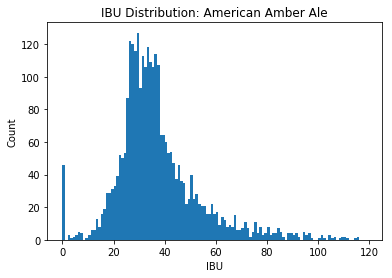

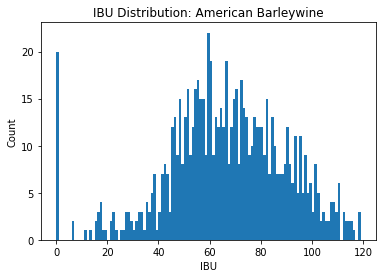

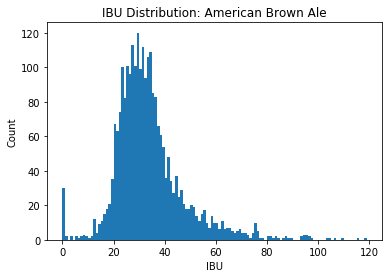

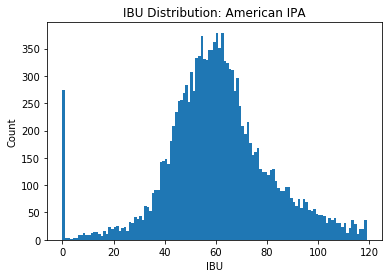

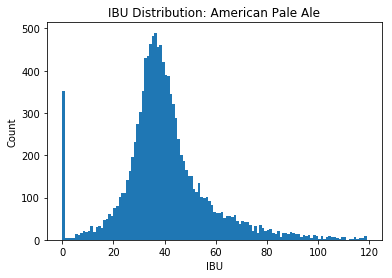

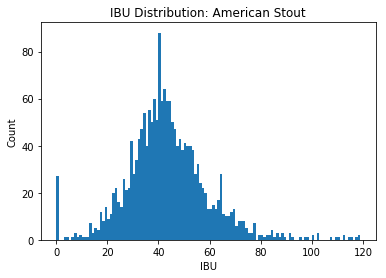

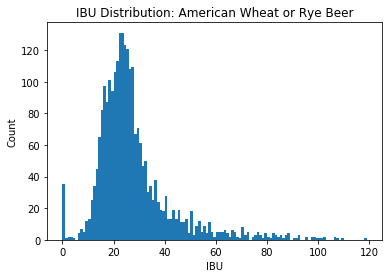

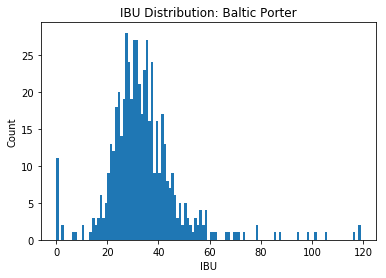

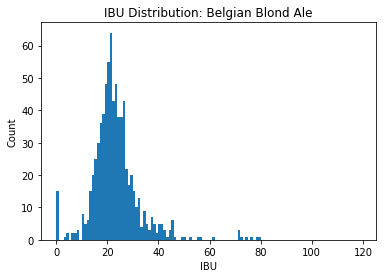

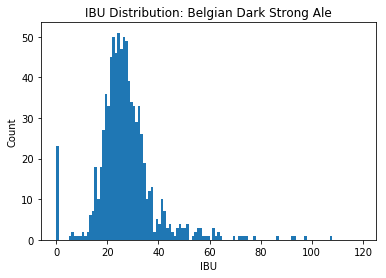

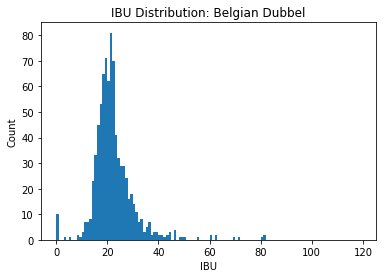

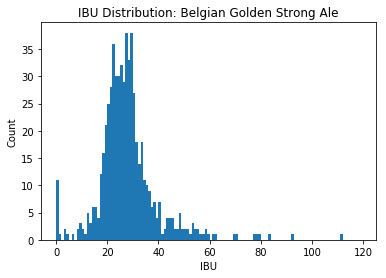

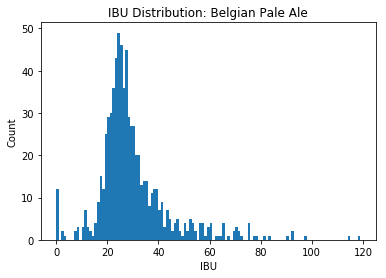

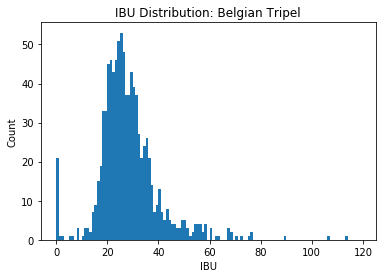

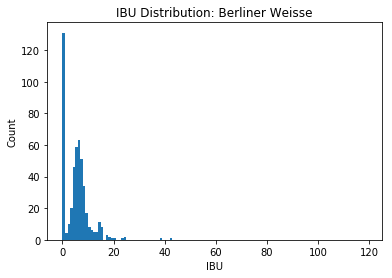

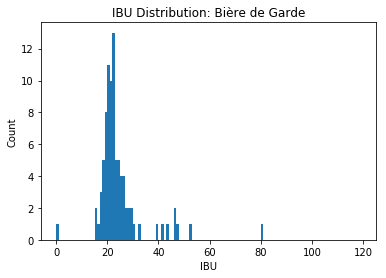

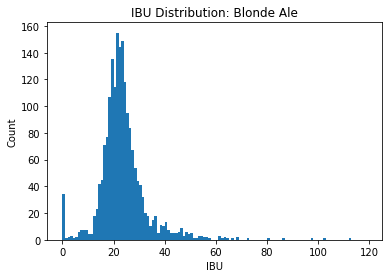

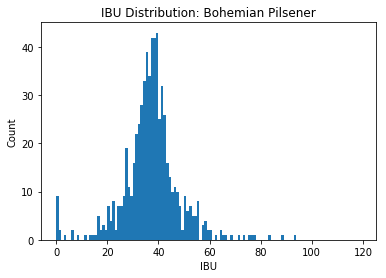

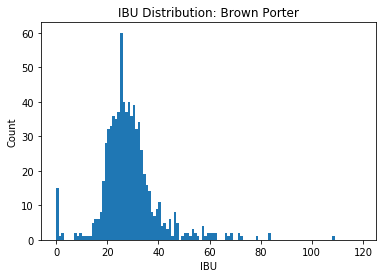

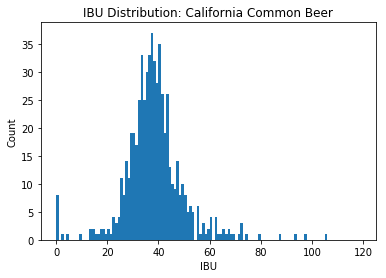

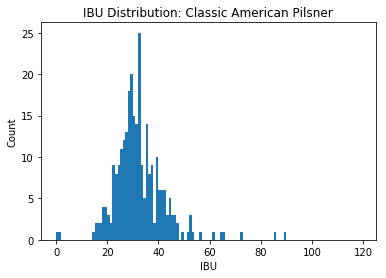

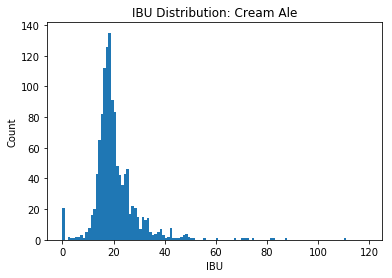

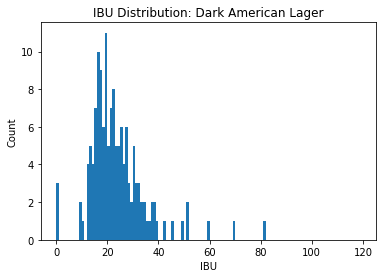

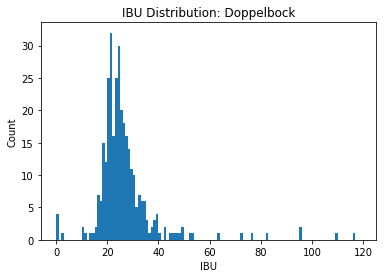

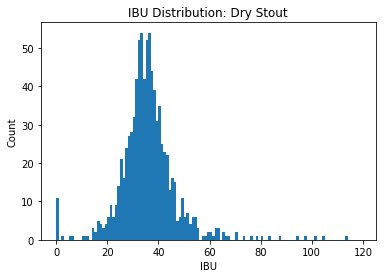

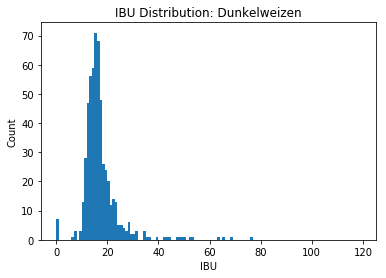

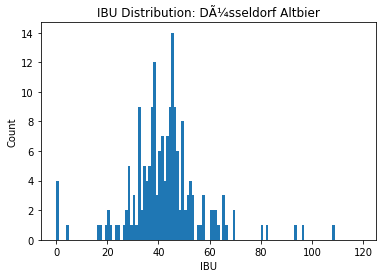

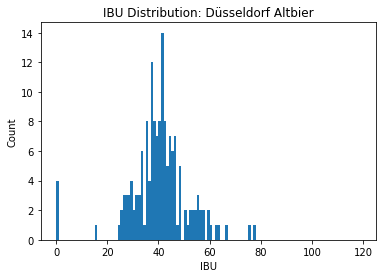

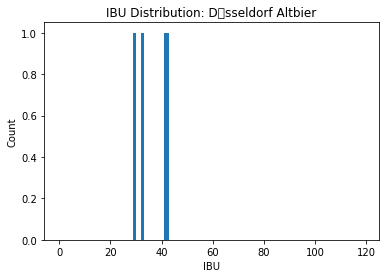

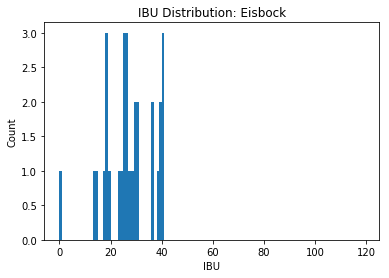

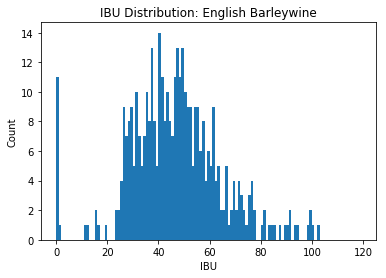

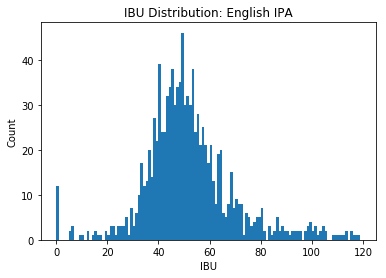

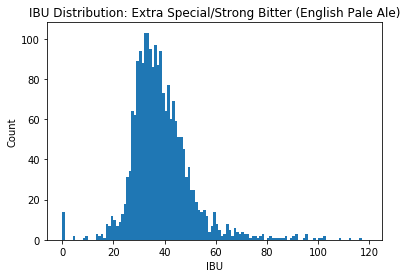

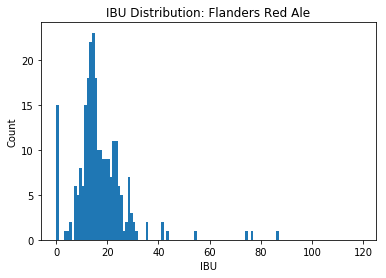

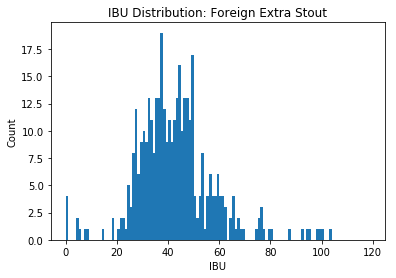

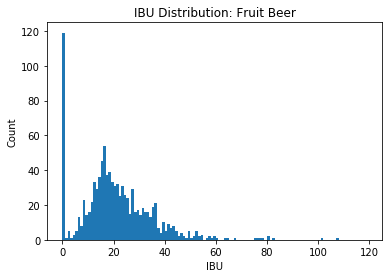

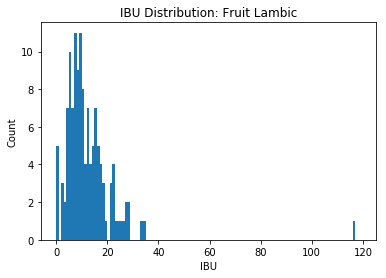

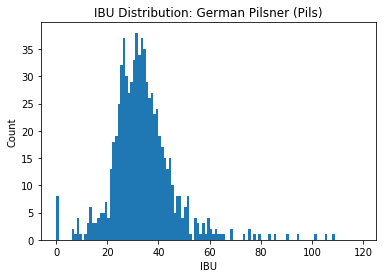

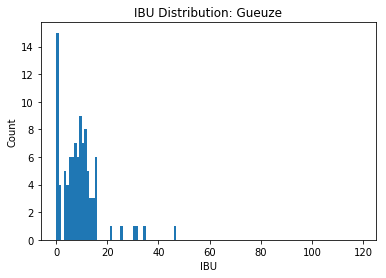

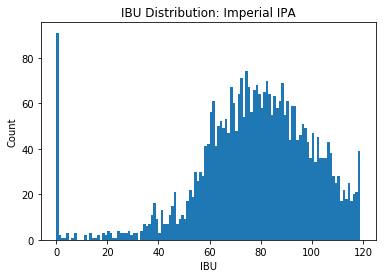

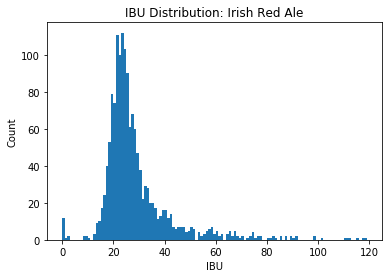

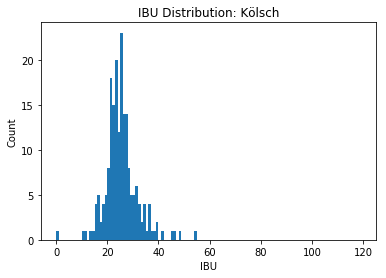

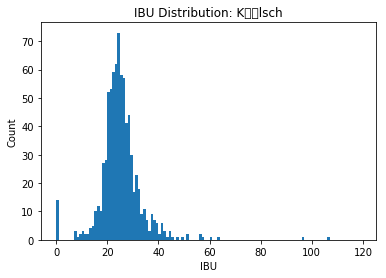

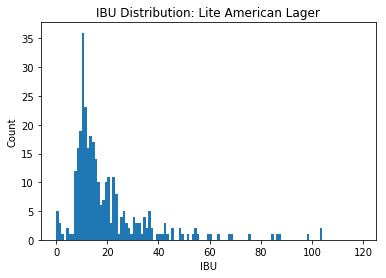

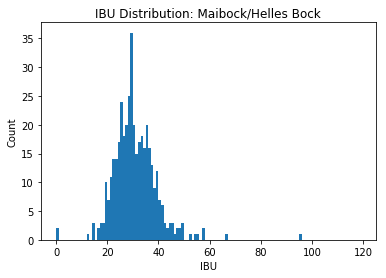

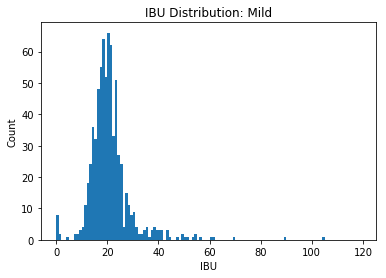

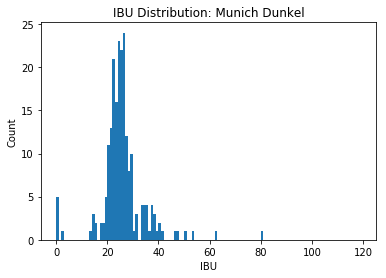

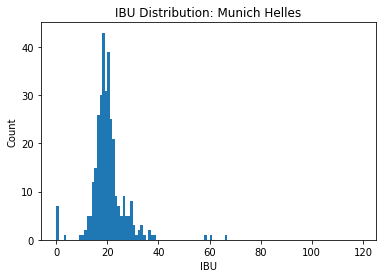

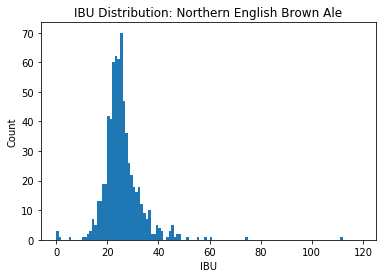

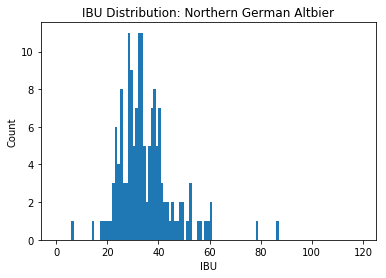

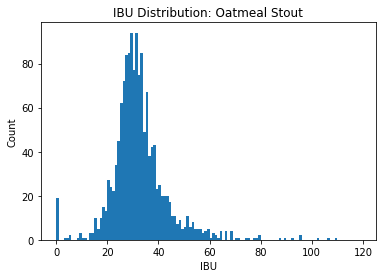

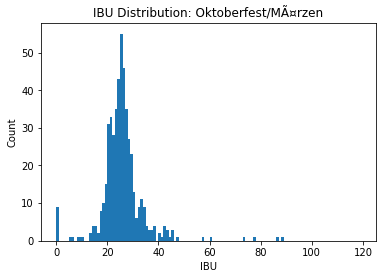

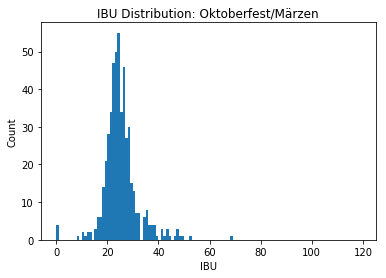

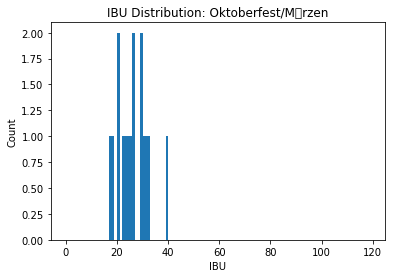

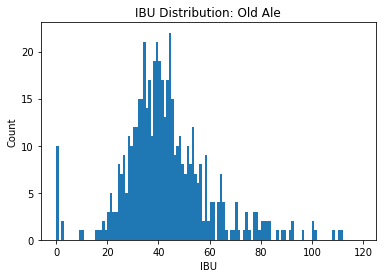

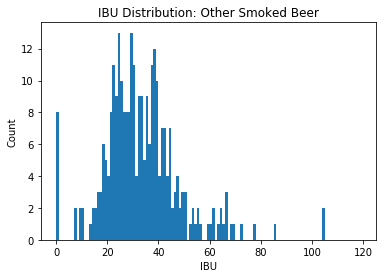

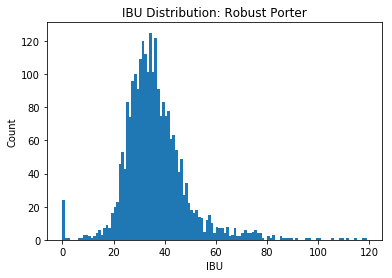

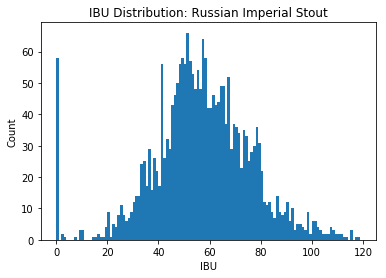

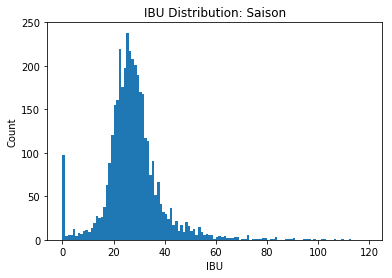

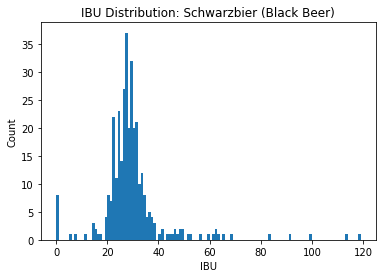

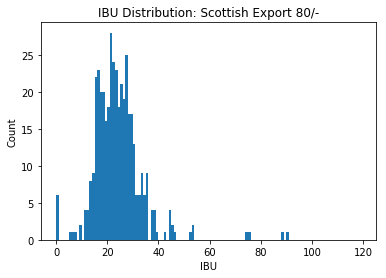

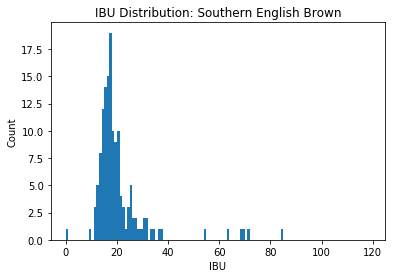

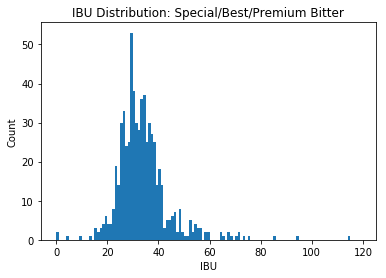

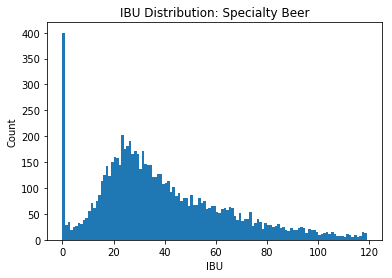

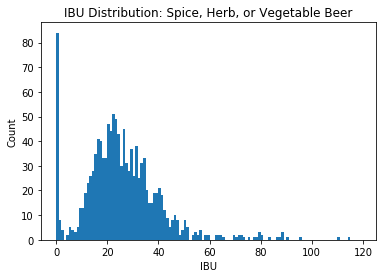

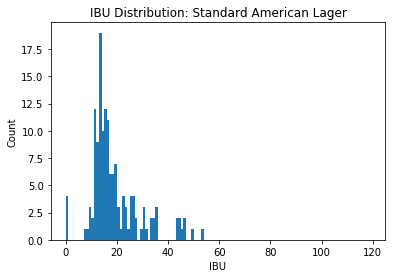

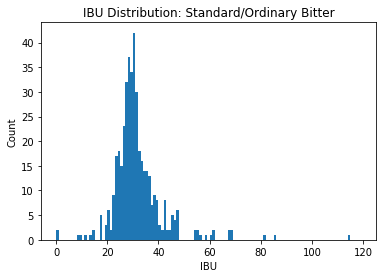

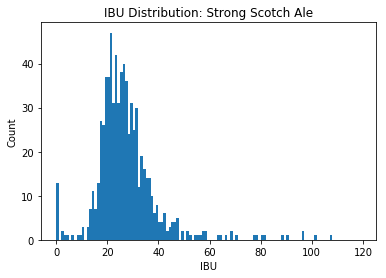

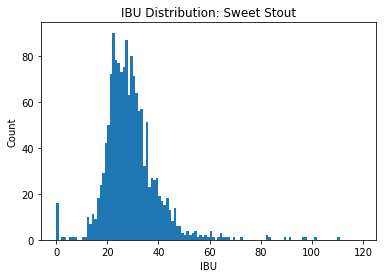

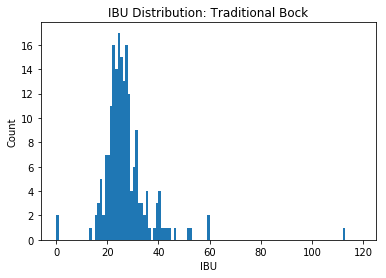

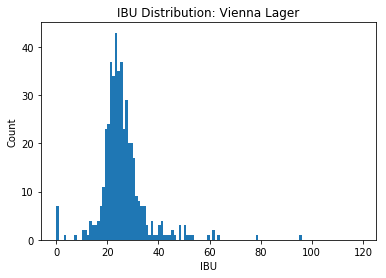

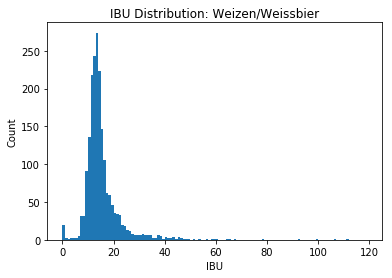

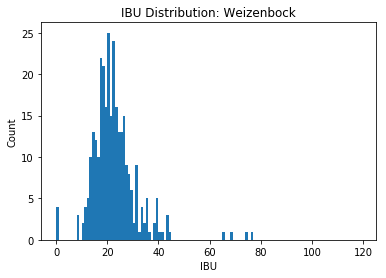

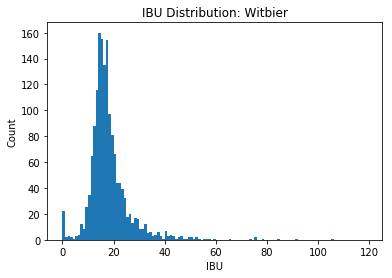

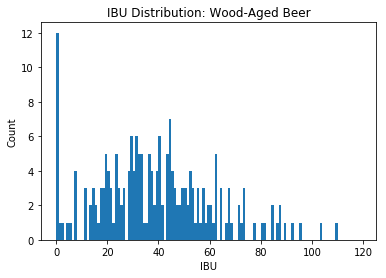

In [32]:
for style in styles:
    ibu = [round(recipe.ibu) for recipe in recipes if recipe.style.name == style]
    plt.title('IBU Distribution: {}'.format(style))
    plt.xlabel('IBU')
    plt.ylabel('Count')
    plt.hist(ibu, bins=range(0, 120))
    plt.show()